In [1]:
import pandas as pd
import yaml
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from modeling import create_model, create_reg_model, update_config

In [238]:
pbp = pd.read_parquet('data/pbp.parquet')
pbp['year'] = pbp['game_id'].apply(lambda x: int(x.split('_')[0]))
pbp['posteam'] = pbp['posteam'].bfill(limit=1)
pbp['defteam'] = pbp['defteam'].bfill(limit=1)
print(pbp.columns)

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'defense_players', 'n_offense', 'n_defense', 'ngs_air_yards',
       'time_to_throw', 'was_pressure', 'route', 'defense_man_zone_type',
       'defense_coverage_type', 'year'],
      dtype='object', length=393)


In [239]:
team = pd.read_csv('data/agg/team_stats.csv', index_col=0)
opp = pd.read_csv('data/agg/opp_stats.csv', index_col=0)
team_stat_cols = [
 'completions_team_roll',
 'attempts_team_roll',
 'carries_team_roll',
 'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'completions_opp_roll',
 'attempts_opp_roll',
 'carries_opp_roll',
 'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll']

In [240]:
pbp = pbp.merge(team, left_on=['posteam','season','week'], right_on=['recent_team','season','week']).drop('recent_team',axis=1)
pbp = pbp.merge(opp, left_on=['defteam','season','week'], right_on=['opponent_team','season','week']).drop('opponent_team',axis=1)


In [241]:
pbp.loc[(pbp.timeout==1)
        & (pbp.posteam==pbp.timeout_team), 'play_type'] = 'pos_timeout'
pbp.loc[(pbp.timeout==1)
        & (pbp.defteam==pbp.timeout_team), 'play_type'] = 'def_timeout'

In [243]:
play_type_mapping = {
    'field_goal': 0,
    'no_play': 1,
    'pass': 2,
    'punt': 3,
    'qb_kneel': 4,
    'qb_spike': 5,
    'run': 6,
    'pos_timeout': 7,
    'def_timeout': 8,
}
pbp["play_type_enc"] = pbp['play_type'].map(play_type_mapping)
pbp.sample(5)

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,pass_pct_team_roll,receiving_yards_team_roll,completions_opp_roll,attempts_opp_roll,carries_opp_roll,passing_yards_opp_roll,rushing_yards_opp_roll,pass_pct_opp_roll,receiving_yards_opp_roll,play_type_enc
164997,175.0,2013_06_CIN_BUF,2013101301,BUF,CIN,REG,6,CIN,away,BUF,...,0.564529,239.857143,21.285714,38.857143,32.142857,279.857143,125.428571,0.551815,279.857143,2.0
719387,2034.0,2024_09_HOU_NYJ,2024103100,NYJ,HOU,REG,9,HOU,away,NYJ,...,0.555136,248.142857,15.285714,28.285714,30.285714,172.571429,126.142857,0.489769,172.571429,6.0
671662,1424.0,2023_10_NYJ_LV,None,LV,NYJ,REG,10,NYJ,away,LV,...,0.625106,221.857143,20.285714,31.714286,29.714286,206.571429,139.142857,0.523089,206.571429,6.0
110415,4298.0,2012_04_SD_KC,2012093002,KC,LAC,REG,4,KC,home,LAC,...,0.538119,262.428571,26.000000,38.857143,19.857143,290.142857,85.142857,0.667932,290.142857,NaN
696475,3421.0,2023_22_SF_KC,None,KC,SF,POST,22,KC,home,SF,...,0.559902,242.285714,23.285714,35.285714,27.571429,227.857143,136.428571,0.563574,227.857143,6.0


In [244]:
pbp[['play_type','play_type_enc']].value_counts()

play_type    play_type_enc
pass         2.0              302737
run          6.0              214182
no_play      1.0               38374
punt         3.0               36445
field_goal   0.0               15914
pos_timeout  7.0               15503
def_timeout  8.0               14891
qb_kneel     4.0                6266
qb_spike     5.0                1082
Name: count, dtype: int64

In [27]:
small = pbp.loc[pbp.year>2021].dropna(how='all',axis=1)
context_cols = ['play_id','game_id','home_team','away_team','game_half','posteam','side_of_field','desc']
small.loc[~small.down.isna()][context_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...
594876,89.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:29) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...
594878,136.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(14:01) (No Huddle, Shotgun) 19-J.Flacco pass ..."
594879,172.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,"(13:53) 7-B.Mann punts 45 yards to BAL 19, Cen..."
...,...,...,...,...,...,...,...,...
728379,4171.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,HOU,(1:29) (Shotgun) 7-C.Stroud pass incomplete de...
728380,4194.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,HOU,(1:23) (Shotgun) 7-C.Stroud sacked at HOU 1 fo...
728382,4214.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,HOU,(1:17) (Shotgun) 7-C.Stroud sacked in End Zone...
728385,4281.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,HOU,(1:12) 8-W.Levis kneels to HOU 30 for -1 yards.


In [28]:
phi = pbp.loc[pbp.game_id=='2024_12_PHI_LA'].copy()
phi[['game_id','time','end_clock_time', 'play_type','yards_gained','desc']] 

,game_id,time,end_clock_time,play_type,yards_gained,desc
727547,2024_12_PHI_LA,15:00,None,None,NaN,GAME
727548,2024_12_PHI_LA,15:00,2024-11-25T01:23:15.290Z,kickoff,0.0,10-B.Mann kicks 65 yards from PHI 35 to end zo...
727549,2024_12_PHI_LA,15:00,2024-11-25T01:23:54.943Z,pass,7.0,(15:00) 9-M.Stafford pass short right to 17-P....
727550,2024_12_PHI_LA,14:31,2024-11-25T01:24:26.877Z,run,4.0,(14:31) 23-K.Williams up the middle to LA 41 f...
727551,2024_12_PHI_LA,13:51,2024-11-25T01:25:10.333Z,run,15.0,(13:51) 9-M.Stafford scrambles up the middle t...
...,...,...,...,...,...,...
727720,2024_12_PHI_LA,01:07,2024-11-25T04:32:40.013Z,no_play,0.0,42-E.Evans kicks onside 8 yards from LA 35 to ...
727721,2024_12_PHI_LA,01:06,2024-11-25T04:33:59.230Z,kickoff,0.0,42-E.Evans kicks onside 10 yards from LA 45 to...
727722,2024_12_PHI_LA,01:05,2024-11-25T04:35:00.223Z,qb_kneel,-1.0,(1:05) 7-K.Pickett kneels to PHI 44 for -1 yards.
727723,2024_12_PHI_LA,00:31,2024-11-25T04:35:33.480Z,qb_kneel,-1.0,(:31) 7-K.Pickett kneels to PHI 43 for -1 yards.


In [90]:
df = pbp[['game_id','desc', 'play_type','quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining', 'yards_gained','air_yards','incomplete_pass','out_of_bounds', 'timeout', 'sp', 'play_type_enc']].copy()
df['time_elapsed'] = df['half_seconds_remaining'] - df.groupby('game_id')['half_seconds_remaining'].shift(-1)
df['clock_stopped'] = 0
df.loc[(df.out_of_bounds ==1 )
       | (df.timeout==1)
       | (df.incomplete_pass==1)
       | (df.sp ==1)
       | (df.play_type.isin(['no_play',None])), 'clock_stopped'] = 1
df


,game_id,desc,play_type,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,yards_gained,air_yards,incomplete_pass,out_of_bounds,timeout,sp,play_type_enc,time_elapsed,clock_stopped
0,2010_01_ARI_STL,GAME,None,900.0,1800.0,3600.0,NaN,NaN,NaN,0.0,NaN,0.0,9.0,0.0,1
1,2010_01_ARI_STL,3-Josh.Brown kicks 70 yards from LA 30 to ARI 0. 36-L.Stephens-Howling to ARI 22 for 22 yards (99-C.Ah You).,kickoff,900.0,1800.0,3600.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,5.0,0
2,2010_01_ARI_STL,(14:55) 3-D.Anderson pass short right to 83-S.Spach to ARI 22 for no gain (55-J.Laurinaitis).,pass,895.0,1795.0,3595.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,31.0,0
3,2010_01_ARI_STL,(14:24) 34-T.Hightower left end to ARI 27 for 5 yards (32-B.Fletcher).,run,864.0,1764.0,3564.0,5.0,NaN,0.0,0.0,0.0,0.0,6.0,41.0,0
4,2010_01_ARI_STL,(13:43) (Shotgun) 3-D.Anderson pass short right to 11-L.Fitzgerald pushed ob at ARI 45 for 18 yards (21-O.Atogwe).,pass,823.0,1723.0,3523.0,18.0,7.0,0.0,1.0,0.0,0.0,2.0,26.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728383,2024_12_TEN_HOU,Timeout #2 by TEN at 01:13.,pos_timeout,73.0,73.0,73.0,0.0,NaN,0.0,0.0,1.0,0.0,7.0,0.0,1
728384,2024_12_TEN_HOU,"15-K.Fairbairn kicks onside 9 yards from HOU 20 to HOU 29, out of bounds.",kickoff,73.0,73.0,73.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,1.0,0
728385,2024_12_TEN_HOU,(1:12) 8-W.Levis kneels to HOU 30 for -1 yards.,qb_kneel,72.0,72.0,72.0,-1.0,NaN,0.0,0.0,0.0,0.0,4.0,35.0,0
728386,2024_12_TEN_HOU,(:37) 8-W.Levis kneels to HOU 31 for -1 yards.,qb_kneel,37.0,37.0,37.0,-1.0,NaN,0.0,0.0,0.0,0.0,4.0,37.0,0


In [91]:
df['play_type'] = df['play_type'].astype("category")

In [92]:
df['next_play'] = df.groupby('game_id')['play_type'].shift(-1)

In [93]:
pd.set_option('display.max_colwidth',130)
phi = df.loc[df.game_id=='2024_12_TEN_HOU'].copy()
phi.head(25)

,game_id,desc,play_type,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,yards_gained,air_yards,incomplete_pass,out_of_bounds,timeout,sp,play_type_enc,time_elapsed,clock_stopped,next_play
728211,2024_12_TEN_HOU,GAME,NaN,900.0,1800.0,3600.0,NaN,NaN,NaN,0.0,NaN,0.0,9.0,0.0,1,kickoff
728212,2024_12_TEN_HOU,6-N.Folk kicks 64 yards from TEN 35 to HOU 1. 31-D.Pierce pushed ob at TEN 19 for 80 yards (26-J.Hardee).,kickoff,900.0,1800.0,3600.0,0.0,NaN,0.0,1.0,0.0,0.0,NaN,13.0,1,pass
728213,2024_12_TEN_HOU,"(14:47) (Shotgun) 7-C.Stroud pass deep right to 87-C.Stover for 19 yards, TOUCHDOWN.",pass,887.0,1787.0,3587.0,19.0,19.0,0.0,0.0,0.0,1.0,2.0,5.0,1,extra_point
728214,2024_12_TEN_HOU,"15-K.Fairbairn extra point is GOOD, Center-46-J.Weeks, Holder-6-T.Townsend.",extra_point,882.0,1782.0,3582.0,0.0,NaN,0.0,0.0,0.0,1.0,NaN,0.0,1,kickoff
728215,2024_12_TEN_HOU,15-K.Fairbairn kicks 65 yards from HOU 35 to TEN 0. 36-J.Chestnut to TEN 39 for 39 yards (23-E.Murray).,kickoff,882.0,1782.0,3582.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,6.0,0,pass
728216,2024_12_TEN_HOU,(14:36) 8-W.Levis pass short left to 83-T.Boyd pushed ob at HOU 42 for 19 yards (21-C.Bullock).,pass,876.0,1776.0,3576.0,19.0,13.0,0.0,1.0,0.0,0.0,2.0,36.0,1,run
728217,2024_12_TEN_HOU,"(14:00) (Shotgun) 20-T.Pollard up the middle to HOU 40 for 2 yards (0-A.Al-Shaair; 98-T.Settle). PENALTY on HOU-97-M.Edwards, ...",run,840.0,1740.0,3540.0,2.0,NaN,0.0,0.0,0.0,0.0,6.0,22.0,0,run
728218,2024_12_TEN_HOU,(13:38) (Shotgun) 20-T.Pollard up the middle to HOU 29 for 6 yards (20-J.Ward).,run,818.0,1718.0,3518.0,6.0,NaN,0.0,0.0,0.0,0.0,6.0,39.0,0,no_play
728219,2024_12_TEN_HOU,"(12:59) (Shotgun) PENALTY on TEN-20-T.Pollard, False Start, 5 yards, enforced at HOU 29 - No Play.",no_play,779.0,1679.0,3479.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,18.0,1,pass
728220,2024_12_TEN_HOU,(12:41) (Shotgun) 8-W.Levis pass short left to 83-T.Boyd to HOU 31 for 3 yards (0-A.Al-Shaair).,pass,761.0,1661.0,3461.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,43.0,0,pass


In [ ]:
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)

def create_reg_model(df, x_cols, y_col):
    data = df.loc[~(df[y_col].isna())].copy(deep=True)
    X, y = data[x_cols], data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = xgb.XGBRegressor(
        objective="reg:squarederror", n_estimators=100, colsample_bytree=0.5, enable_categorical=True
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    return model


clock_x = ['play_type','quarter_seconds_remaining','half_seconds_remaining', 'game_seconds_remaining', 'yards_gained','incomplete_pass','out_of_bounds', 'timeout', 'sp','next_play']
clock_y = 'time_elapsed'
clock_model = create_reg_model(df, clock_x, clock_y)

_ ='''Mean Squared Error: 146.3997344970703
R-squared: 0.9920598268508911
'''

Mean Squared Error: 146.3997344970703
R-squared: 0.9920598268508911


In [98]:
joblib.dump(clock_model, 'models/clock_model.joblib')

feature_config = {
    'clock_cols':clock_x,
}
update_config(feature_config)

In [96]:
pbp.loc[pbp.complete_pass==1][['pass_location', 'out_of_bounds']].groupby('pass_location').value_counts(normalize=True)

pass_location  out_of_bounds
left           0.0              0.760394
               1.0              0.239606
middle         0.0              0.965870
               1.0              0.034130
right          0.0              0.761360
               1.0              0.238640
Name: proportion, dtype: float64

In [97]:
test = df.iloc[100:110].copy()
test['pred'] = clock_model.predict(df[clock_x].iloc[100:110])
test

,game_id,desc,play_type,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,yards_gained,air_yards,incomplete_pass,out_of_bounds,timeout,sp,play_type_enc,time_elapsed,clock_stopped,next_play,pred
100,2010_01_ARI_STL,(14:27) 39-S.Jackson up the middle to LA 18 for -4 yards (25-K.Rhodes).,run,867.0,1767.0,1767.0,-4.0,NaN,0.0,0.0,0.0,0.0,6.0,41.0,0,pass,38.992104
101,2010_01_ARI_STL,(13:46) (Shotgun) 8-S.Bradford pass short right to 39-S.Jackson to LA 21 for 3 yards (22-M.Ware).,pass,826.0,1726.0,1726.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,36.0,0,punt,36.628082
102,2010_01_ARI_STL,"(13:10) 5-D.Jones punts 63 yards to ARI 16, Center-45-C.Massey. 18-M.Komar to ARI 22 for 6 yards (56-J.Hull). FUMBLES (56-J.Hu...",punt,790.0,1690.0,1690.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0,13.0,0,run,9.792187
103,2010_01_ARI_STL,(12:57) 36-L.Stephens-Howling right guard to ARI 23 for 1 yard (59-L.Grant).,run,777.0,1677.0,1677.0,1.0,NaN,0.0,0.0,0.0,0.0,6.0,34.0,0,pass,38.372005
104,2010_01_ARI_STL,(12:23) 3-D.Anderson pass incomplete short right to 48-J.Johnson.,pass,743.0,1643.0,1643.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,5.0,1,pass,4.902504
105,2010_01_ARI_STL,"(12:18) (Shotgun) 3-D.Anderson FUMBLES (Aborted) at ARI 18, and recovers at ARI 18. 3-D.Anderson pass incomplete short left. P...",pass,738.0,1638.0,1638.0,0.0,7.0,1.0,0.0,0.0,0.0,2.0,4.0,1,no_play,5.130187
106,2010_01_ARI_STL,"(12:14) 5-B.Graham punts 52 yards to LA 35, Center-82-M.Leach. 16-D.Amendola to LA 34 for -1 yards (27-M.Adams). PENALTY on AR...",no_play,734.0,1634.0,1634.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,9.0,1,punt,9.932328
107,2010_01_ARI_STL,"(12:05) 5-B.Graham punts 42 yards to LA 45, Center-82-M.Leach. 16-D.Amendola to ARI 38 for 17 yards (49-R.Johnson).",punt,725.0,1625.0,1625.0,0.0,NaN,0.0,0.0,0.0,0.0,3.0,11.0,0,run,9.762534
108,2010_01_ARI_STL,(11:54) 39-S.Jackson right end pushed ob at ARI 27 for 11 yards (24-A.Wilson).,run,714.0,1614.0,1614.0,11.0,NaN,0.0,1.0,0.0,0.0,6.0,35.0,1,pass,32.105350
109,2010_01_ARI_STL,(11:19) 8-S.Bradford pass short left to 89-M.Clayton pushed ob at ARI 25 for 2 yards (28-G.Toler).,pass,679.0,1579.0,1579.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,30.0,1,pass,31.075399


In [245]:
x_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    #"total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
    'quarter'
] + team_stat_cols

pbp['quarter'] = pbp['qtr']
y_col = ["play_type_enc"]
data = pbp.loc[~pbp.play_type_enc.isna(), x_cols + y_col+['game_id']].copy()
data.loc[data.play_type_enc.isin([7,8]),'ydstogo'] = None
data[x_cols] = data.groupby('game_id')[x_cols].ffill(limit=1)
data = data.loc[~data.play_type_enc.isna()]


In [246]:
pbp['temp'].value_counts()

temp
 58.0    123260
 61.0     33932
 43.0     28199
 70.0     27479
 86.0     25948
          ...  
 10.0       166
 94.0       165
 1.0        163
 6.0        159
-6.0        156
Name: count, Length: 94, dtype: int64

In [247]:
data[y_col].value_counts()

play_type_enc
2.0              302737
6.0              214182
1.0               38374
3.0               36445
0.0               15914
7.0               15503
8.0               14891
4.0                6266
5.0                1082
Name: count, dtype: int64

In [249]:
np.set_printoptions(linewidth=100)
play_type_model = create_model(data, x_cols, y_col[0], colsample_bytree=0.8)
print(x_cols)
#0.67
_ = '''array([[ 550,    1,   21,   13,    0,    4,   16],
       [  25,    0,  806,   55,    3,    0,  410],
       [  48,    9, 8092,   32,    5,    4, 2771],
       [   4,    2,   13, 1165,    0,    0,   15],
       [   0,    0,   18,    0,  202,    0,   16],
       [  10,    0,   24,    0,    0,    3,    0],
       [  16,    2, 2933,   27,   21,    1, 5137]], dtype=int64)'''

Accuracy: 0.65
Confusion Matrix:


array([[ 2934,     3,    94,    62,     1,     8,    92,    17,     3],
       [  154,    86,  4565,   384,     9,     2,  2521,     7,    18],
       [  180,    18, 44522,   192,    33,    19, 15506,   105,   122],
       [   55,     6,    49,  7233,     0,     0,    33,     0,     0],
       [    1,     3,    59,     0,  1053,     0,    65,    13,    19],
       [   40,     0,   165,     0,     0,    10,     1,     1,     4],
       [   85,     7, 14761,   150,    85,     2, 27187,    62,   305],
       [   37,     2,  1606,    17,    45,     1,   587,   622,   108],
       [   34,     1,  1151,    13,    43,    14,   749,   175,   763]], dtype=int64)

['yardline_100', 'down', 'goal_to_go', 'ydstogo', 'posteam_score', 'score_differential', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'wind', 'temp', 'spread_line', 'total_line', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'quarter', 'completions_team_roll', 'attempts_team_roll', 'carries_team_roll', 'passing_yards_team_roll', 'rushing_yards_team_roll', 'pass_pct_team_roll', 'completions_opp_roll', 'attempts_opp_roll', 'carries_opp_roll', 'passing_yards_opp_roll', 'rushing_yards_opp_roll', 'pass_pct_opp_roll']


In [250]:
test = data.loc[(data.quarter==4)
                & (data.play_type_enc==8.0)].sample(10)

In [251]:
test[x_cols[0:16]+y_col]

,yardline_100,down,goal_to_go,ydstogo,posteam_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,temp,spread_line,total_line,posteam_timeouts_remaining,defteam_timeouts_remaining,quarter,play_type_enc
412720,45.0,3.0,0,10.0,28.0,0.0,41.0,41.0,41.0,8.0,89.0,-7.5,40.5,2.0,2.0,4.0,8.0
64612,80.0,1.0,0,10.0,20.0,7.0,154.0,154.0,154.0,7.0,68.0,-3.0,46.5,2.0,2.0,4.0,8.0
480596,NaN,NaN,0,NaN,NaN,NaN,108.0,108.0,108.0,5.0,58.0,-1.0,41.5,NaN,NaN,4.0,8.0
661212,50.0,1.0,0,10.0,20.0,7.0,177.0,177.0,177.0,5.0,58.0,-2.0,42.5,2.0,3.0,4.0,8.0
397962,39.0,1.0,0,10.0,24.0,1.0,54.0,54.0,54.0,10.0,62.0,6.5,45.0,0.0,2.0,4.0,8.0
182509,77.0,2.0,0,8.0,23.0,3.0,164.0,164.0,164.0,10.0,19.0,6.0,44.5,3.0,2.0,4.0,8.0
273127,41.0,1.0,0,10.0,22.0,3.0,67.0,67.0,67.0,9.0,63.0,3.5,49.0,2.0,1.0,4.0,8.0
198228,35.0,3.0,0,1.0,27.0,18.0,158.0,158.0,158.0,5.0,40.0,13.0,41.0,2.0,3.0,4.0,8.0
272945,69.0,1.0,0,10.0,17.0,1.0,113.0,113.0,113.0,0.0,58.0,-9.5,43.5,2.0,1.0,4.0,8.0
597156,49.0,1.0,0,10.0,38.0,3.0,115.0,115.0,115.0,5.0,58.0,-6.0,49.0,1.0,2.0,4.0,8.0


In [252]:
test.loc[test.play_type_enc == 8.0][x_cols].mean()

yardline_100                   53.888889
down                            1.555556
goal_to_go                      0.000000
ydstogo                         8.777778
posteam_score                  24.333334
score_differential              4.777778
quarter_seconds_remaining     115.099998
half_seconds_remaining        115.099998
game_seconds_remaining        115.099998
wind                            6.400000
temp                           57.299999
spread_line                     0.000000
total_line                     44.299999
posteam_timeouts_remaining      1.777778
defteam_timeouts_remaining      2.000000
quarter                         4.000000
completions_team_roll          19.442857
attempts_team_roll             31.228571
carries_team_roll              26.757143
passing_yards_team_roll       230.400000
rushing_yards_team_roll       116.214286
pass_pct_team_roll              0.536542
completions_opp_roll           20.514286
attempts_opp_roll              32.400000
carries_opp_roll

In [253]:
pbp.loc[pbp.index==58052].dropna(axis=1).to_dict(orient='records')

[{'play_id': 3922.0,
  'game_id': '2011_04_CAR_CHI',
  'old_game_id': '2011100205',
  'home_team': 'CHI',
  'away_team': 'CAR',
  'season_type': 'REG',
  'week': 4,
  'posteam': 'CHI',
  'defteam': 'CAR',
  'game_date': '2011-10-02',
  'quarter_seconds_remaining': 88.0,
  'half_seconds_remaining': 88.0,
  'game_seconds_remaining': 88.0,
  'game_half': 'Half2',
  'quarter_end': 0.0,
  'drive': 21.0,
  'sp': 0.0,
  'qtr': 4.0,
  'goal_to_go': 0,
  'time': '01:28',
  'yrdln': 'CAR 3',
  'ydstogo': 0.0,
  'ydsnet': 43.0,
  'desc': 'Timeout #1 by CAR at 01:28.',
  'play_type': 'def_timeout',
  'yards_gained': 0.0,
  'shotgun': 0.0,
  'no_huddle': 0.0,
  'qb_dropback': 0.0,
  'qb_kneel': 0.0,
  'qb_spike': 0.0,
  'qb_scramble': 0.0,
  'home_timeouts_remaining': 0.0,
  'away_timeouts_remaining': 1.0,
  'timeout': 1.0,
  'timeout_team': 'CAR',
  'total_home_score': 27.0,
  'total_away_score': 23.0,
  'no_score_prob': 0.0,
  'opp_fg_prob': 0.0,
  'opp_safety_prob': 0.0,
  'opp_td_prob': 0.0,
  

In [254]:
np.round(1000 * play_type_model.predict_proba(test[x_cols]))

array([[  0.,  35., 419.,   0.,   4.,   0.,  42., 278., 222.],
       [  0.,  37.,  77.,   0.,   0.,   0., 575.,  11., 300.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  78., 921.],
       [  0.,  32.,  73.,   0.,   0.,   0., 621.,  11., 263.],
       [  1.,  74.,  87.,   0.,  64.,  91., 207.,   3., 472.],
       [  0.,  22., 166.,   0.,   0.,   0., 362.,  19., 430.],
       [  0.,  21.,  30.,   0., 416.,   0., 160.,  79., 294.],
       [  0.,  16.,   9.,   0.,   0.,   0., 157., 129., 690.],
       [  0.,  23.,  66.,   0.,   8.,   0., 334.,  60., 508.],
       [  0.,  32.,  69.,   0.,   5.,   0., 565.,   7., 322.]], dtype=float32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

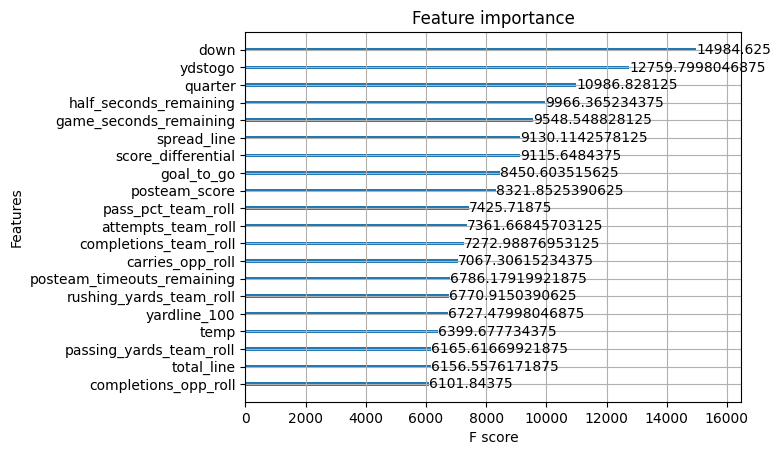

In [255]:
xgb.plot_importance(play_type_model,importance_type= 'cover', max_num_features=20)

In [256]:
joblib.dump(play_type_model, 'models/run_or_pass.joblib')

['models/run_or_pass.joblib']

In [257]:
{k:v for v,k in play_type_mapping.items()}

{0: 'field_goal',
 1: 'no_play',
 2: 'pass',
 3: 'punt',
 4: 'qb_kneel',
 5: 'qb_spike',
 6: 'run',
 7: 'pos_timeout',
 8: 'def_timeout'}

In [258]:
feature_config = {
    'run_or_pass_cols':x_cols,
    'play_encoding': {k:v for v,k in play_type_mapping.items()}
}
update_config(feature_config)

In [38]:
r_data = small.loc[small.rush==1]
r_data
rx_cols = [
    #'posteam',
    "yardline_100",
    "down",
    "goal_to_go",
    "ydstogo",
    #"yards_gained",
    "posteam_score",
    "total_away_score",
    "score_differential",
    'quarter_seconds_remaining',
    'half_seconds_remaining',
    'game_seconds_remaining',
    "wind",
    "temp",
    'spread_line',
    'total_line'
]
r_data[context_cols + rx_cols]

,play_id,game_id,home_team,away_team,game_half,posteam,side_of_field,desc,yardline_100,down,...,posteam_score,total_away_score,score_differential,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,wind,temp,spread_line,total_line
594875,68.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:56) 32-Mi.Carter left end to NYJ 41 for 19...,78.0,1.0,...,0.0,0.0,0.0,896.0,1796.0,3596.0,8.554289,57.110649,6.5,44.0
594877,115.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,NYJ,NYJ,(14:25) (No Huddle) 32-Mi.Carter left end to N...,59.0,2.0,...,0.0,0.0,0.0,865.0,1765.0,3565.0,8.554289,57.110649,6.5,44.0
594882,254.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:41) (Shotgun) 8-L.Jackson right tackle to ...,64.0,3.0,...,0.0,0.0,0.0,761.0,1661.0,3461.0,8.554289,57.110649,-6.5,44.0
594883,275.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(12:01) (Shotgun) 17-K.Drake right end to BAL ...,60.0,1.0,...,0.0,0.0,0.0,721.0,1621.0,3421.0,8.554289,57.110649,-6.5,44.0
594885,330.0,2022_01_BAL_NYJ,NYJ,BAL,Half1,BAL,BAL,(10:40) 17-K.Drake right tackle to BAL 49 for ...,52.0,3.0,...,0.0,0.0,0.0,640.0,1540.0,3340.0,8.554289,57.110649,-6.5,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728356,3609.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,TEN,(7:56) (No Huddle) 28-J.Mixon up the middle to...,47.0,1.0,...,27.0,30.0,-3.0,476.0,476.0,476.0,5.000000,58.000000,-8.0,40.5
728360,3707.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,TEN,(6:17) 20-T.Pollard right end to TEN 2 for -4 ...,94.0,1.0,...,30.0,30.0,3.0,377.0,377.0,377.0,5.000000,58.000000,8.0,40.5
728370,3978.0,2024_12_TEN_HOU,HOU,TEN,Half2,HOU,TEN,(2:12) 28-J.Mixon left tackle to TEN 10 for no...,10.0,2.0,...,27.0,30.0,-3.0,132.0,132.0,132.0,5.000000,58.000000,-8.0,40.5
728373,4051.0,2024_12_TEN_HOU,HOU,TEN,Half2,TEN,TEN,(1:53) 61-J.Ojukwu reported in as eligible. 20...,80.0,1.0,...,30.0,30.0,3.0,113.0,113.0,113.0,5.000000,58.000000,8.0,40.5
